<a href="https://colab.research.google.com/github/Yi-Wei-Lin/Tibame_ML_20210602/blob/main/Cabbage_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Recurrent Neural Network



# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Importing the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train-1.csv')
training_set = dataset_train.iloc[:, 1:2].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
time_step = 60
data_len = len(training_set_scaled)
for i in range(time_step, data_len):
    X_train.append(training_set_scaled[i-time_step : i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.33, random_state=42)

In [ ]:
dataset_train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1001,12/24/2015,749.55,751.35,746.62,748.4,"527,200"
1002,12/28/2015,752.92,762.99,749.52,762.51,"1,515,300"
1003,12/29/2015,766.69,779.98,766.43,776.6,"1,765,000"
1004,12/30/2015,776.60,777.60,766.90,771,"1,293,300"


In [ ]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
callback = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ModelCheckpoint("regressor.h5", save_best_only=True)
]
regressor.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_split=0.1, callbacks=callback)

Epoch 1/200
27/27 [==============================] - 7s 69ms/step - loss: 0.0789 - val_loss: 0.0150
Epoch 2/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 3/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0040 - val_loss: 0.0121
Epoch 4/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0041 - val_loss: 0.0121
Epoch 5/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 6/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0060
Epoch 7/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0112
Epoch 8/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 9/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 10/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0037 - val_loss: 0.0090

In [ ]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test-1.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_step :].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
test_data_len = len(inputs)
for i in range(time_step, test_data_len):
    X_test.append(inputs[i-time_step : i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
len(dataset_total) - len(dataset_test) - time_step

946

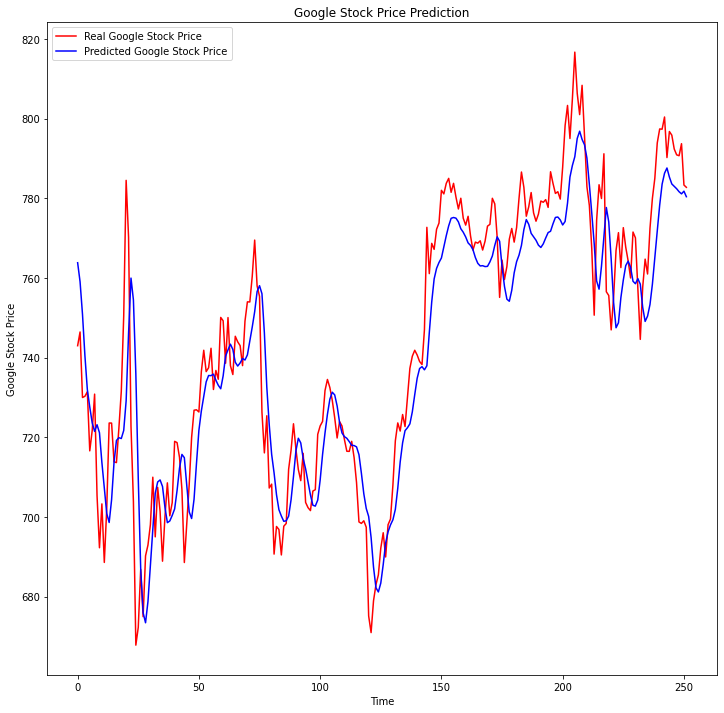

In [ ]:
# Visualising the results
plt.figure(figsize=(12,12))
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()